# Introduction

## Lab2: Train a Convolutional Neural Network (CNN).

In this Lab session we will learn how to train a CNN from scratch for classifying MNIST digits.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T

### Define LeNet

![network architecture](https://www.researchgate.net/profile/Lucijano-Berus/publication/329891470/figure/fig1/AS:707347647307776@1545656229128/Architecture-of-LeNet-5-a-Convolutional-Neural-Network-for-digits-digits-recognition-An.ppm)

Here we are going to define our first CNN which is **LeNet** in this case. This architecture has been introduced and is detailed in [this article](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf). To construct a LeNet we will be using some convolutional layers followed by some fully-connected layers. The convolutional layers can be simply defined using `torch.nn.Conv2d` module of `torch.nn` package. Details can be found [here](https://pytorch.org/docs/stable/nn.html#conv2d). Moreover, we will use pooling operation to reduce the size of convolutional feature maps. For this case we are going to use `torch.nn.functional.max_pool2d`. Details about maxpooling can be found [here](https://pytorch.org/docs/stable/nn.html#max-pool2d)

Differently from our previous Lab, we will use a Rectified Linear Units (ReLU) as activation function with the help of `torch.nn.functional.relu`, replacing `torch.nn.Sigmoid`. Details about ReLU can be found [here](https://pytorch.org/docs/stable/nn.html#id26).

In [2]:
class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        input_shape = 32
        num_c_channels = 1

        conv1_out_channels = 6
        conv1_kernel_size = 5
        maxpool1_kernel_size = 2
        maxpool1_stride = 2

        conv2_out_channels = 16
        conv2_kernel_size = 5
        maxpool2_kernel_size = 2
        maxpool2_stride = 2

        fc1_out_features = 120
        fc2_out_features = 84
        num_classes = 10

        conv1_output_shape = input_shape - (conv1_kernel_size - 1)
        maxpool1_output_shape = (
            conv1_output_shape - (maxpool1_kernel_size - 1) - 1
        ) // maxpool1_stride + 1

        conv2_output_shape = maxpool1_output_shape - (conv2_kernel_size - 1)
        maxpool2_output_shape = (
            conv2_output_shape - (maxpool2_kernel_size - 1) - 1
        ) // maxpool2_stride + 1

        # input channel = 1, output channels = 6, kernel size = 5
        # input image size = (32, 32), image output size = (28, 28)
        self.conv1 = nn.Conv2d(
            in_channels=num_c_channels,
            out_channels=conv1_out_channels,
            kernel_size=conv1_kernel_size,

        )
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(
            kernel_size=maxpool1_kernel_size, stride=maxpool1_stride
        )

        # input channel = 6, output channels = 16, kernel size = 5
        # input image size = (14, 14), output image size = (5, 5)
        self.conv2 = nn.Conv2d(
            in_channels=conv1_out_channels,
            out_channels=conv2_out_channels,
            kernel_size=conv2_kernel_size,
        )
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(
            kernel_size=maxpool2_kernel_size, stride=maxpool2_stride
        )

        # input dim = 400 (H x W x C), output dim = 120
        self.fc1 = nn.Linear(
            in_features=conv2_out_channels * (maxpool2_output_shape**2),
            out_features=fc1_out_features,
        )
        self.relu3 = nn.ReLU()

        # input dim = 120, output dim = 84
        self.fc2 = nn.Linear(in_features=fc1_out_features, out_features=fc2_out_features)
        self.relu4 = nn.ReLU()

        # input dim = 84, output dim = 10
        self.fc3 = nn.Linear(in_features=fc2_out_features, out_features=num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        # Max Pooling with kernel size = 2
        # output size = (14, 14)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        # Max Pooling with kernel size = 2
        # output size = (5, 5)
        x = self.maxpool2(x)

        # flatten the feature maps into a long vector
        x = x.view(x.shape[0], -1)

        x = self.fc1(x)
        x = self.relu3(x)

        x = self.fc2(x)
        x = self.relu4(x)

        x = self.fc3(x)
        x = self.softmax(x)

        return x

### Define cost function

In [3]:
def get_cost_function():
    cost_function = nn.BCELoss()
    return cost_function

### Define the optimizer

We will use SGD with learning rate-lr, weight_decay=wd and  momentum=momentum

In [4]:
def get_optimizer(net, lr, wd, momentum):
    optimizer = torch.optim.SGD(
        net.parameters(), lr=lr, weight_decay=wd, momentum=momentum
    )
    return optimizer

### Train and test functions

In [5]:
def test(
    net,
    data_loader,
    cost_function,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    samples = 0.0
    cumulative_loss = 0.0
    cumulative_accuracy = 0.0

    net.eval()  # Strictly needed if network contains layers which has different behaviours between train and test
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            # Load data into GPU
            inputs = inputs.to(device).to(torch.float32)
            targets = targets.to(device)
            one_hot_targets = F.one_hot(targets, num_classes=10).to(torch.float32)

            # Forward pass
            outputs = net(inputs)

            # Apply the loss
            loss = cost_function(outputs, one_hot_targets)

            # Better print something
            samples += inputs.shape[0]
            cumulative_loss += (
                loss.item()
            )  # Note: the .item() is needed to extract scalars from tensors
            _, predicted = outputs.max(1)
            cumulative_accuracy += predicted.eq(targets).sum().item()

    return cumulative_loss / samples, cumulative_accuracy / samples * 100


def train(
    net,
    data_loader,
    optimizer,
    cost_function,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    samples = 0.0
    cumulative_loss = 0.0
    cumulative_accuracy = 0.0

    net.train()  # Strictly needed if network contains layers which has different behaviours between train and test
    for batch_idx, (inputs, targets) in enumerate(data_loader):
        # Load data into GPU
        inputs = inputs.to(device).to(torch.float32)
        targets = targets.to(device)
        one_hot_targets = F.one_hot(targets, num_classes=10).to(torch.float32)

        # Forward pass
        outputs = net(inputs)

        # Apply the loss
        loss = cost_function(outputs, one_hot_targets)

        # Reset the optimizer

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        optimizer.zero_grad()

        # Better print something, no?
        samples += inputs.shape[0]
        cumulative_loss += loss.item()
        _, predicted = outputs.max(1)
        cumulative_accuracy += predicted.eq(targets).sum().item()

    return cumulative_loss / samples, cumulative_accuracy / samples * 100

### Define the function that fetches a data loader that is then used during iterative training.

We will learn a new thing in this function as how to Normalize the inputs given to the network.

***Why Normalization is needed***?

To have nice and stable training of the network it is recommended to normalize the network inputs between \[-1, 1\].

***How it can be done***?

This can be simply done using `torchvision.transforms.Normalize()` transform. Details can be found [here](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize).

In [6]:
def get_data(batch_size, test_batch_size=256):

    # Prepare data transformations and then combine them sequentially
    transform = list()
    # converts Numpy to Pytorch Tensor
    transform.append(T.ToTensor())
    # Normalizes the Tensors between [-1, 1]
    transform.append(T.Normalize(mean=[0.5], std=[0.5]))
    # Normalizes the Tensors with 2 zeros on each size
    transform.append(T.Pad(padding=2))
    # Composes the above transformations into one.
    transform = T.Compose(transform)

    # Load data
    full_training_data = torchvision.datasets.MNIST(
        "./data", train=True, transform=transform, download=True
    )
    test_data = torchvision.datasets.MNIST(
        "./data", train=False, transform=transform, download=True
    )

    # Create train and validation splits
    num_samples = len(full_training_data)
    training_samples = int(num_samples * 0.5 + 1)
    validation_samples = num_samples - training_samples

    training_data, validation_data = torch.utils.data.random_split(
        full_training_data, [training_samples, validation_samples]
    )

    # Initialize dataloaders
    train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(
        validation_data, test_batch_size, shuffle=False
    )
    test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

### Wrapping everything up

Finally, we need a main function which initializes everything + the needed hyperparameters and loops over multiple epochs (printing the results).

In [7]:
"""
Input arguments
  batch_size: Size of a mini-batch
  device: GPU where you want to train your network
  weight_decay: Weight decay co-efficient for regularization of weights
  momentum: Momentum for SGD optimizer
  epochs: Number of epochs for training the network
"""


def main(
    batch_size=128,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    learning_rate=0.01,
    weight_decay=0.000001,
    momentum=0.9,
    epochs=50,
):

    train_loader, val_loader, test_loader = get_data(batch_size)

    net = LeNet().to(device)

    optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

    cost_function = get_cost_function()

    print("Before training:")
    train_loss, train_accuracy = test(net, train_loader, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    test_loss, test_accuracy = test(net, test_loader, cost_function)

    print(f"\t Training loss {train_loss:.5f}, Training accuracy {train_accuracy:.2f}")
    print(f"\t Validation loss {val_loss:.5f}, Validation accuracy {val_accuracy:.2f}")
    print(f"\t Test loss {test_loss:.5f}, Test accuracy {test_accuracy:.2f}")
    print("-----------------------------------------------------")

    for e in range(epochs):
        train_loss, train_accuracy = train(net, train_loader, optimizer, cost_function)
        val_loss, val_accuracy = test(net, val_loader, cost_function)
        print(f"Epoch: {e + 1:d}")
        print(
            f"\t Training loss {train_loss:.5f}, Training accuracy {train_accuracy:.2f}"
        )
        print(
            f"\t Validation loss {val_loss:.5f}, Validation accuracy {val_accuracy:.2f}"
        )
        print("-----------------------------------------------------")

    print("After training:")
    train_loss, train_accuracy = test(net, train_loader, cost_function)
    val_loss, val_accuracy = test(net, val_loader, cost_function)
    test_loss, test_accuracy = test(net, test_loader, cost_function)

    print(f"\t Training loss {train_loss:.5f}, Training accuracy {train_accuracy:.2f}")
    print(f"\t Validation loss {val_loss:.5f}, Validation accuracy {val_accuracy:.2f}")
    print(f"\t Test loss {test_loss:.5f}, Test accuracy {test_accuracy:.2f}")
    print("-----------------------------------------------------")

    return net

Lets train!

In [8]:
net = main()

Before training:
	 Training loss 0.00255, Training accuracy 11.53
	 Validation loss 0.00128, Validation accuracy 11.78
	 Test loss 0.00130, Test accuracy 11.94
-----------------------------------------------------
Epoch: 1
	 Training loss 0.00254, Training accuracy 22.96
	 Validation loss 0.00126, Validation accuracy 37.80
-----------------------------------------------------
Epoch: 2
	 Training loss 0.00243, Training accuracy 34.68
	 Validation loss 0.00109, Validation accuracy 37.96
-----------------------------------------------------
Epoch: 3
	 Training loss 0.00134, Training accuracy 65.61
	 Validation loss 0.00035, Validation accuracy 83.85
-----------------------------------------------------
Epoch: 4
	 Training loss 0.00053, Training accuracy 87.63
	 Validation loss 0.00021, Validation accuracy 90.19
-----------------------------------------------------
Epoch: 5
	 Training loss 0.00036, Training accuracy 91.64
	 Validation loss 0.00016, Validation accuracy 92.63
---------------

Using the proper metric from sklearn, check which character is most frequently confused with which: can you explain why ?



In [11]:
# Set model to evaluation mode to avoid the computation of the gradients

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader, val_loader, test_loader = get_data(128)

# Create an empty list to store the outputs
predictions = []
true_labels = []

net.eval()

# Iterate over the test loader
for batch_images, labels in test_loader:
    batch_images = batch_images.to(device)

    labels = labels.to(device)
    batch_outputs = net(batch_images)

    batch_pred = torch.argmax(batch_outputs, dim=1)
    predictions.append(batch_pred)
    true_labels.append(labels)

# Concatenate the outputs from all batches along the batch dimension
predictions = torch.cat(predictions, dim=0).cpu().numpy()
true_labels = torch.cat(true_labels, dim=0).cpu().numpy()

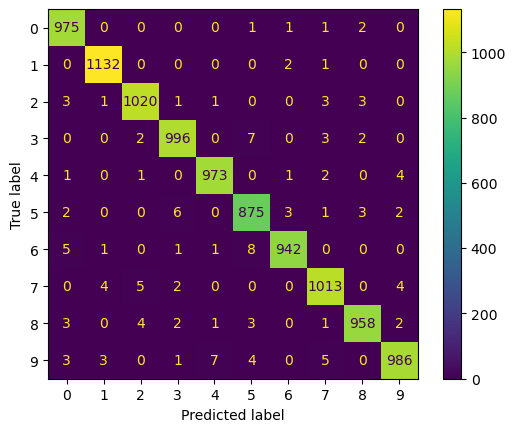

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

The LeNet5 architecture can also be implemented using the sequential API ([see documentation ](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)). Reimplement it with this API.

In [ ]:
net2 = nn.Sequential(
    nn.Conv2d(1, 6, 5),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(6, 16, 5),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(5 * 5 * 16, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10),
    nn.Softmax(dim=1),
)

## Experiments


* Implement adaptive early stopping: if the validation loss did not decrease for K consecutive epochs, stop training.
* Change dataset in order to evaluate the LeNet5 network on cifar10 dataset. You can have a look at the pytorch to easily access the cifar10 dataset.
* Try to improve performance with:
   *   data-augmentation
   *   dropout
* Implement the resnet18 architecture using the Resnet18 class from pytorch.



